# Relational XGBoost - Short term traffic predictions - ASPM Regional roads

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Init" data-toc-modified-id="Init-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Read-the-data" data-toc-modified-id="Read-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read the data</a></span></li><li><span><a href="#Feature-generation" data-toc-modified-id="Feature-generation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature generation</a></span></li><li><span><a href="#Fitting-models-and-predictions" data-toc-modified-id="Fitting-models-and-predictions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fitting models and predictions</a></span><ul class="toc-item"><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li></ul></div>

## Init

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import warnings

warnings.filterwarnings('ignore')


root_dir = "../"

data_dir = f"{root_dir}data/dataframes/per_location/"

locations = [
    "Rabuiese Valico Uscita", "Rabuiese Valico Ingresso", 
    "Fernetti Valico Uscita", "Fernetti Valico Ingresso", 
    "Prosecco Direzione TS", "Prosecco Direzione VE",
    "A34 Ovest dir- Villesse", "A34 Est dir- Gorizia"
]
location_template_feather = data_dir + "{}.feather"

## Read the data

In [2]:
# Here we read the the the data from 1 sensor between March 2015 and December 2018
# We only use non-zero values
# The data is resampled to 1h intervals

dfs = {}
for location in locations:
    data = pd.read_feather(location_template_feather.format(location.replace(" ", "_").lower()))
    
    # Keep only rows with volume greater than 0
    data = data[data["count"] > 0]
    data = data.set_index("timestamp")
   
    # Rename index name and columns
    data.index.names = ['ds']
    data.columns = ['y']
    
    dfs[location] = data

## Feature generation

In [3]:
IT_HOLIDAYS = pd.DataFrame(
    sorted(map(
        lambda date: (pd.to_datetime(date[0]), date[1]), 
        holidays.IT(years=range(2015, 2020)).items()
    )),
    columns=["date", "holiday_name"]
)

In [4]:
def generate_features(data):
    # create date time features of a dataset
    # encode cyclical time features with sin and cos
    # year, month_sin, month_cos, hour_sin, hour_cos, weekday_sin, weekday_cos, weekend, count (target attribute)
    dataframe = pd.DataFrame()
    dataframe['year'] = [data.index[i].year for i in range(len(data))]
    dataframe['month_sin'] = [np.sin((data.index[i].month - 1) * (2. * np.pi / 12)) for i in range(len(data))]
    dataframe['month_cos'] = [np.cos((data.index[i].month - 1) * (2. * np.pi / 12)) for i in range(len(data))]

    #dataframe['day'] = [data.index[i].day for i in range(len(data))]
    dataframe['hour_sin'] = [np.sin(data.index[i].hour * (2. * np.pi / 24)) for i in range(len(data))]
    dataframe['hour_cos'] = [np.cos(data.index[i].hour * (2. * np.pi / 24)) for i in range(len(data))]
    dataframe['weekday_sin'] = [np.sin(data.index[i].weekday() * (2. * np.pi / 7)) for i in range(len(data))]
    dataframe['weekday_cos'] = [np.cos(data.index[i].weekday() * (2. * np.pi / 7)) for i in range(len(data))]
    dataframe['weekend'] = [(data.index[i].weekday() > 4) * 1 for i in range(len(data))]
    dataframe['count'] = [data['y'][i] for i in range(len(data))]
    
    
    # Holidays
    # Add additional features for the holidays
    holidays_it = holidays.IT(years=range(2015, 2019))
    dataframe['holiday'] = pd.Series(data.index.date).isin(holidays_it) * 1
    dataframe['date'] = pd.Series(data.index)
    
    # add lagged features
    for i in range(1, 24):
        dataframe['lag_{}'.format(i)] = dataframe["count"].shift(i)
    dataframe['lag_{}'.format(48)] = dataframe["count"].shift(48)
    dataframe['lag_{}'.format(72)] = dataframe["count"].shift(72)
    dataframe['lag_{}'.format(168)] = dataframe["count"].shift(168)
    dataframe
    
    return dataframe

In [5]:
dataframes = {}
for location in locations:
    dataframes[location] = generate_features(dfs[location])

## Fitting models and predictions

In [6]:
 # model evaluation - cross validation
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

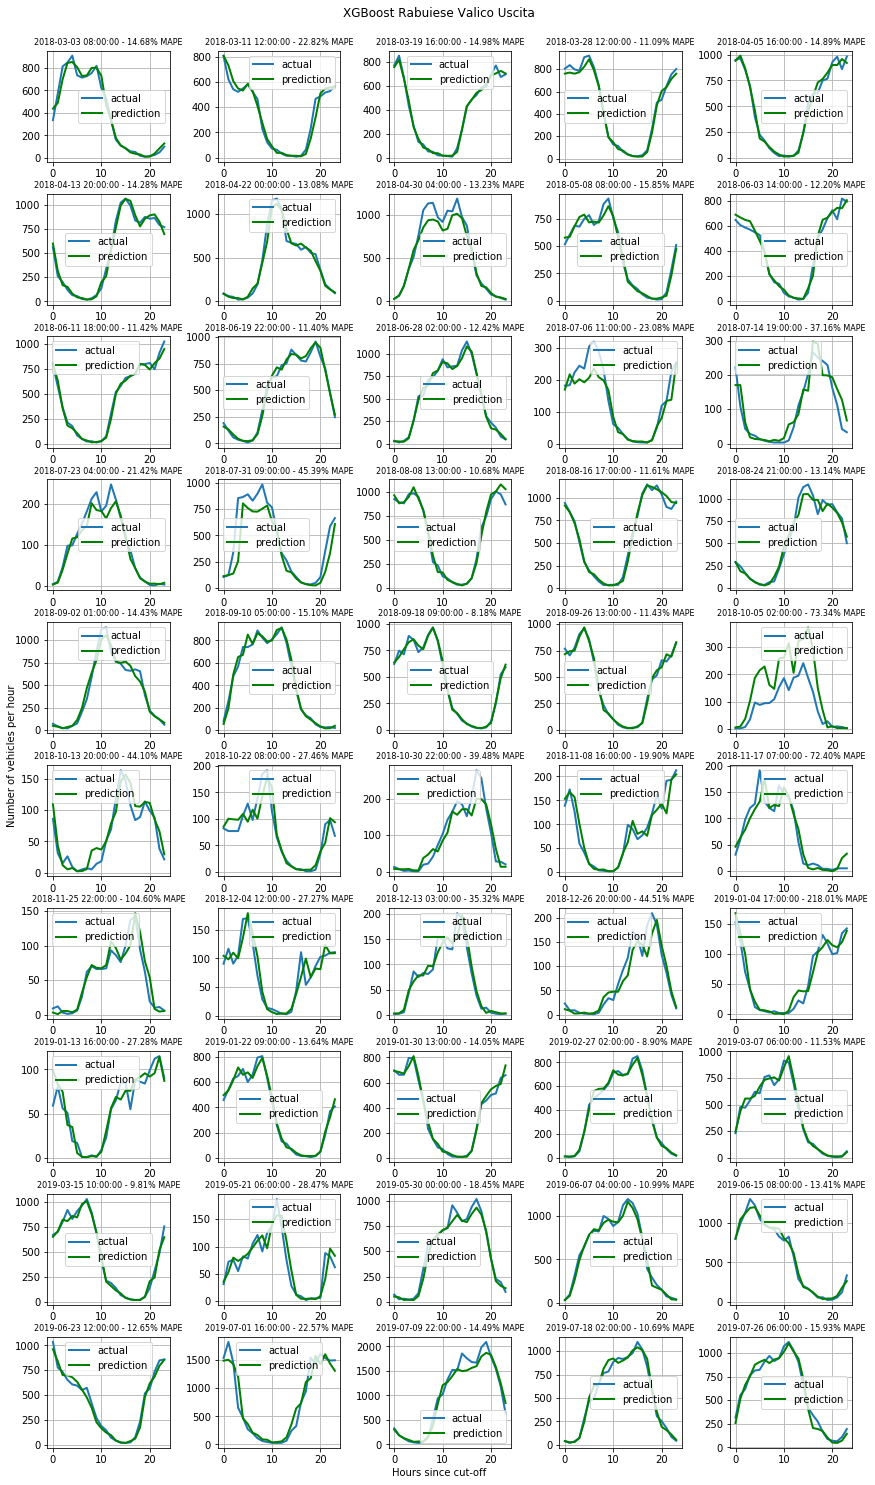

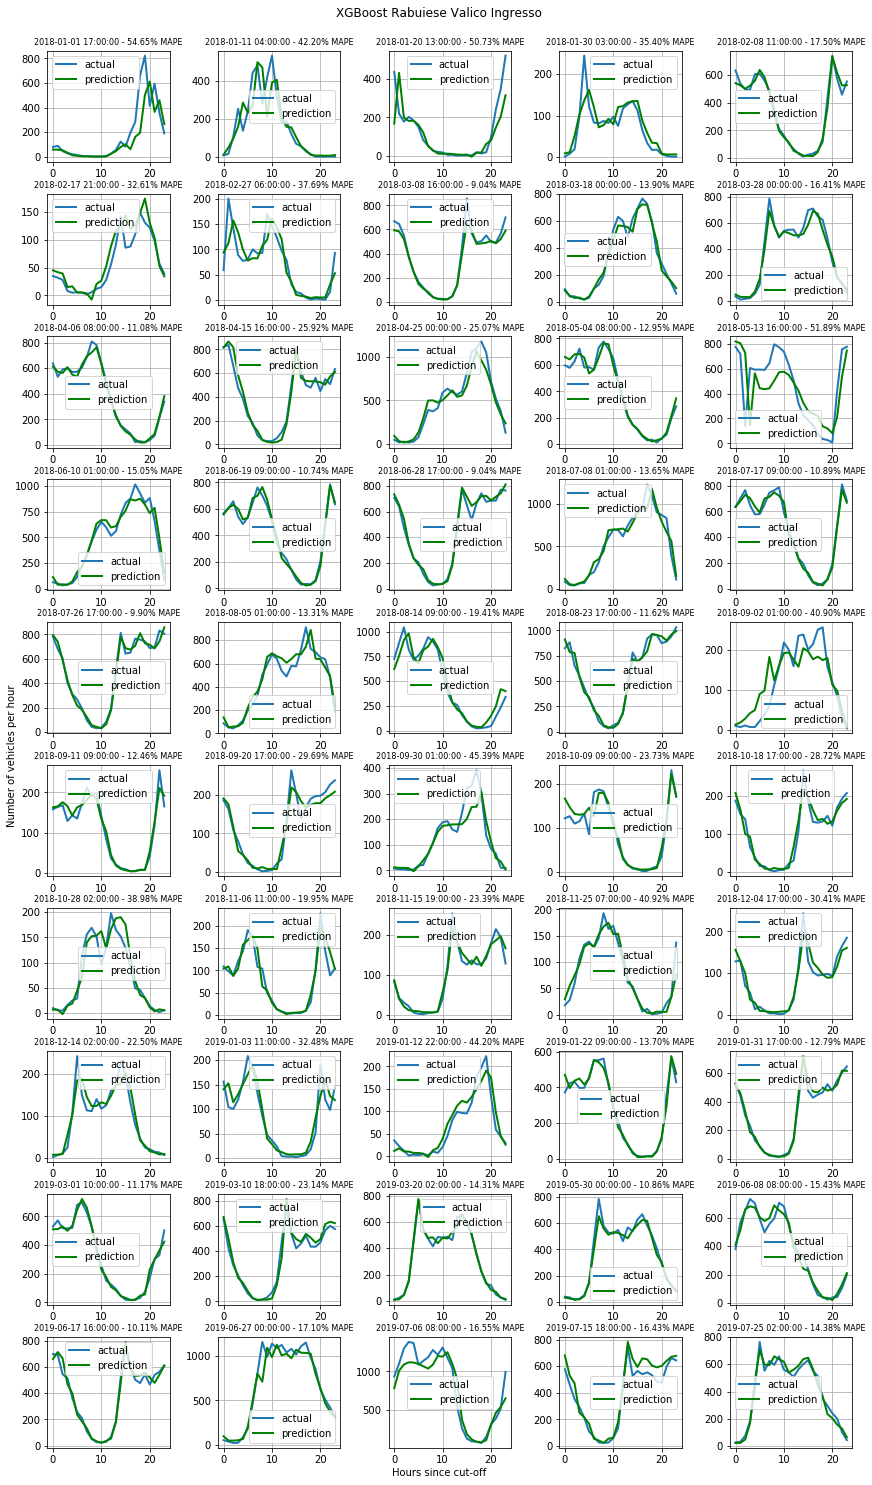

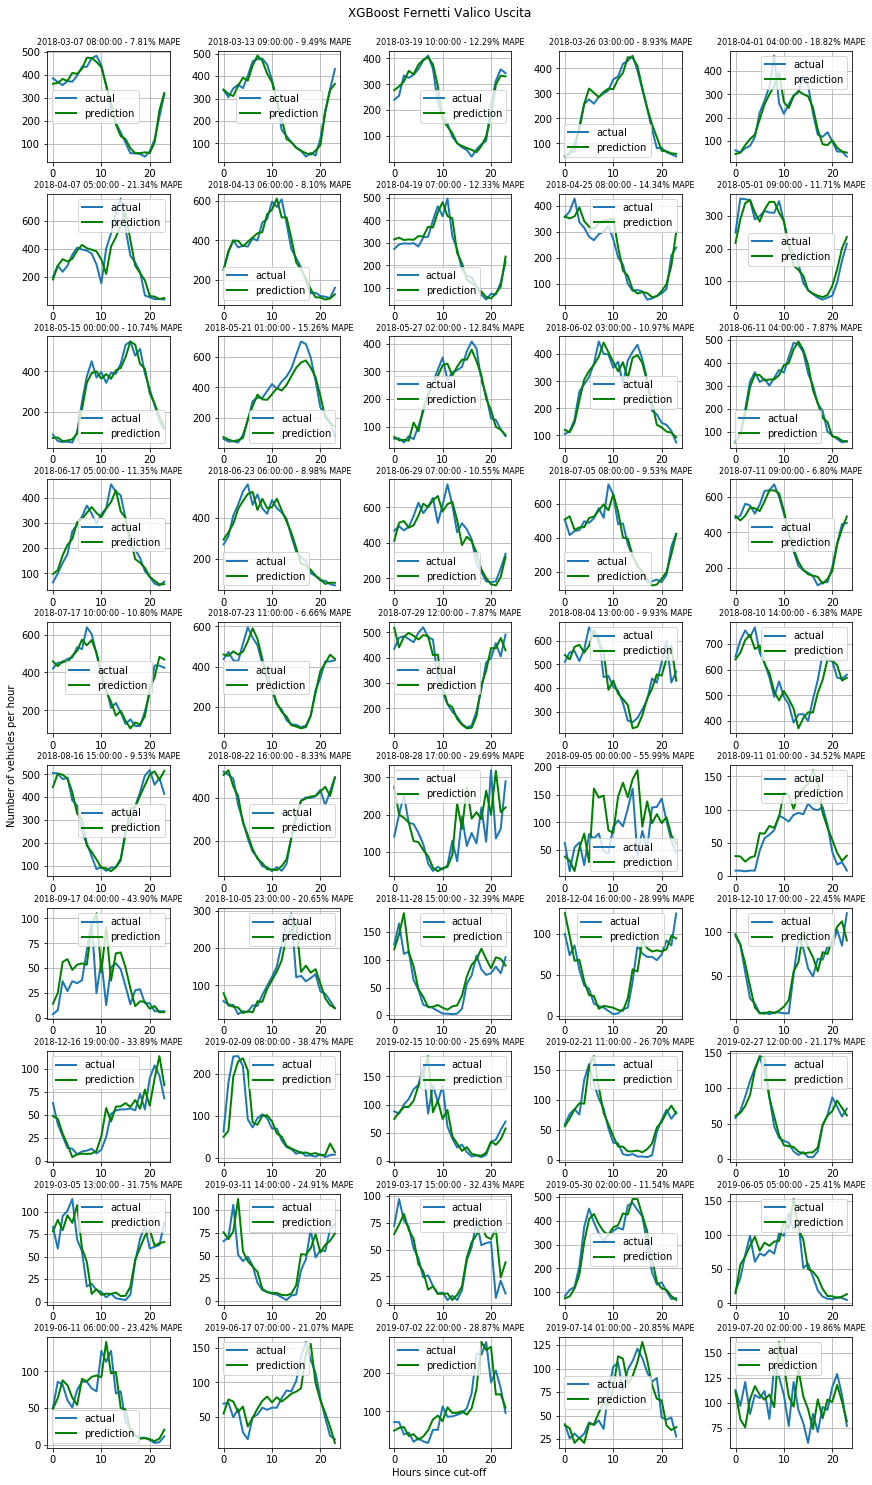

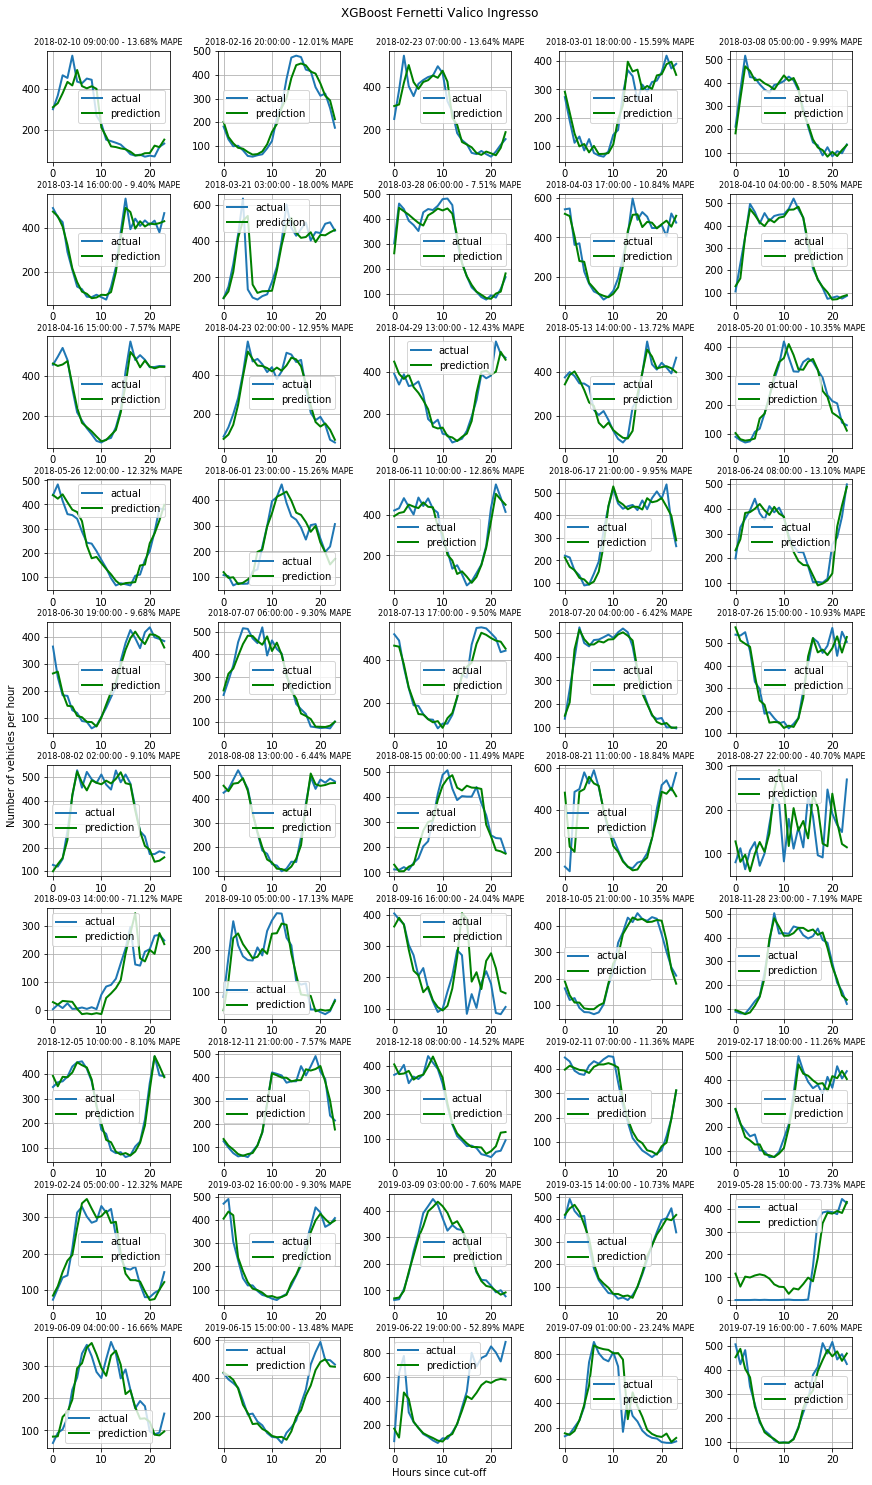

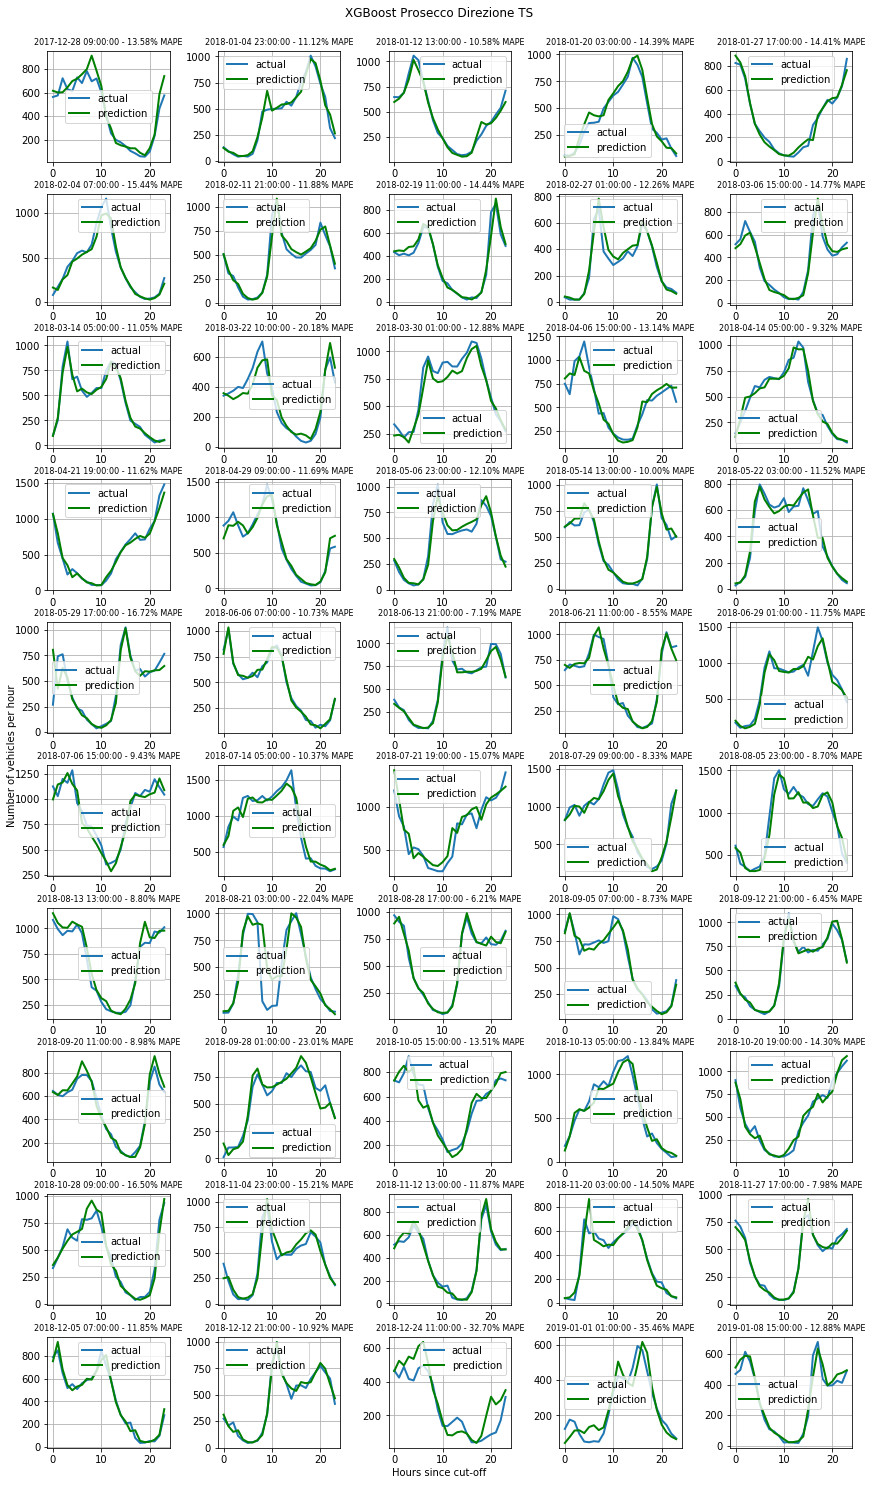

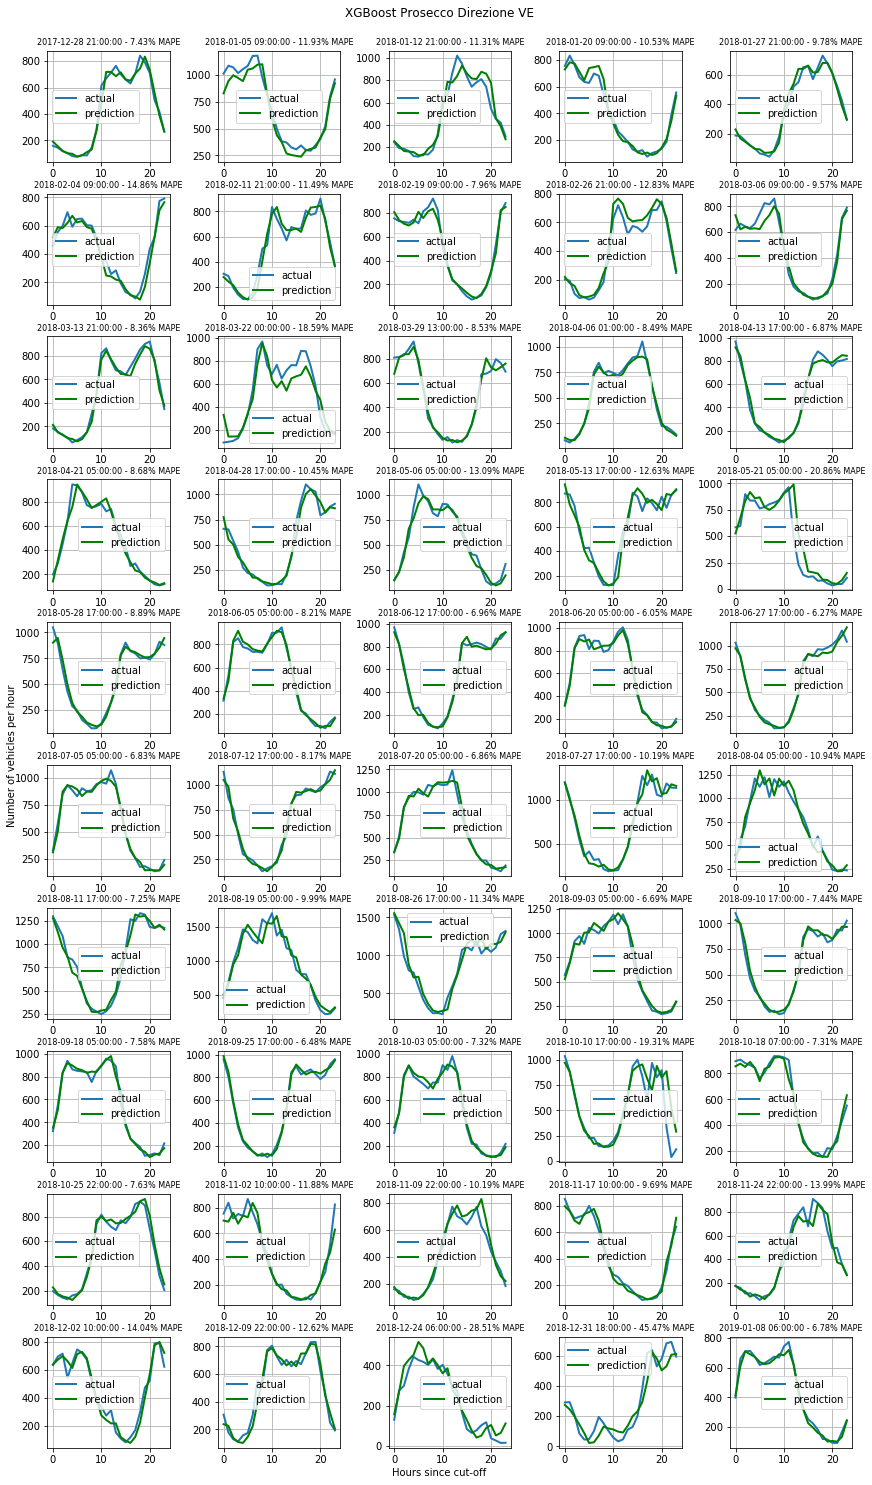

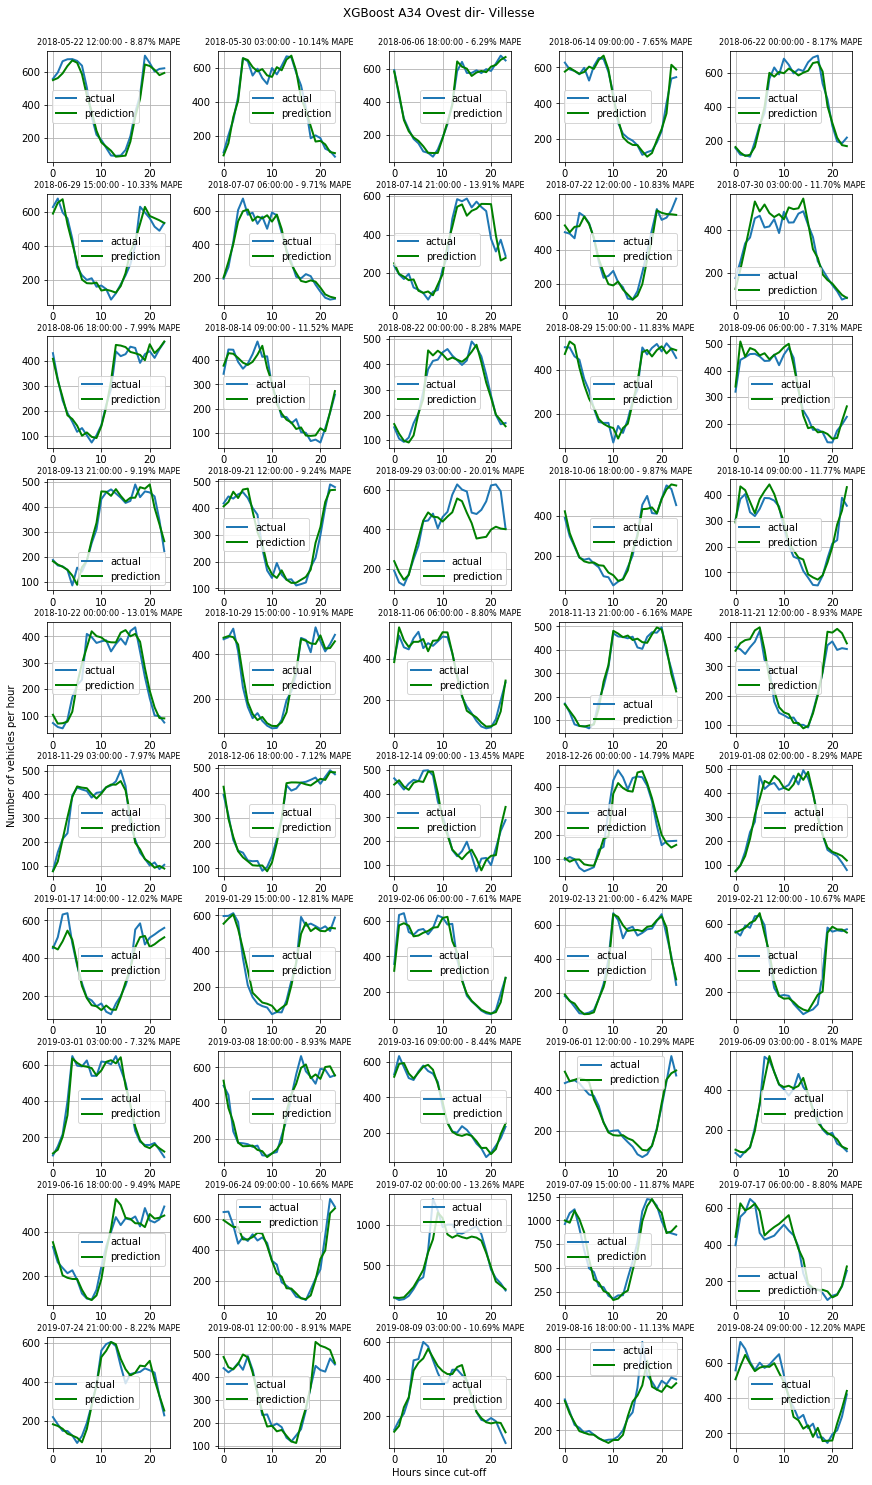

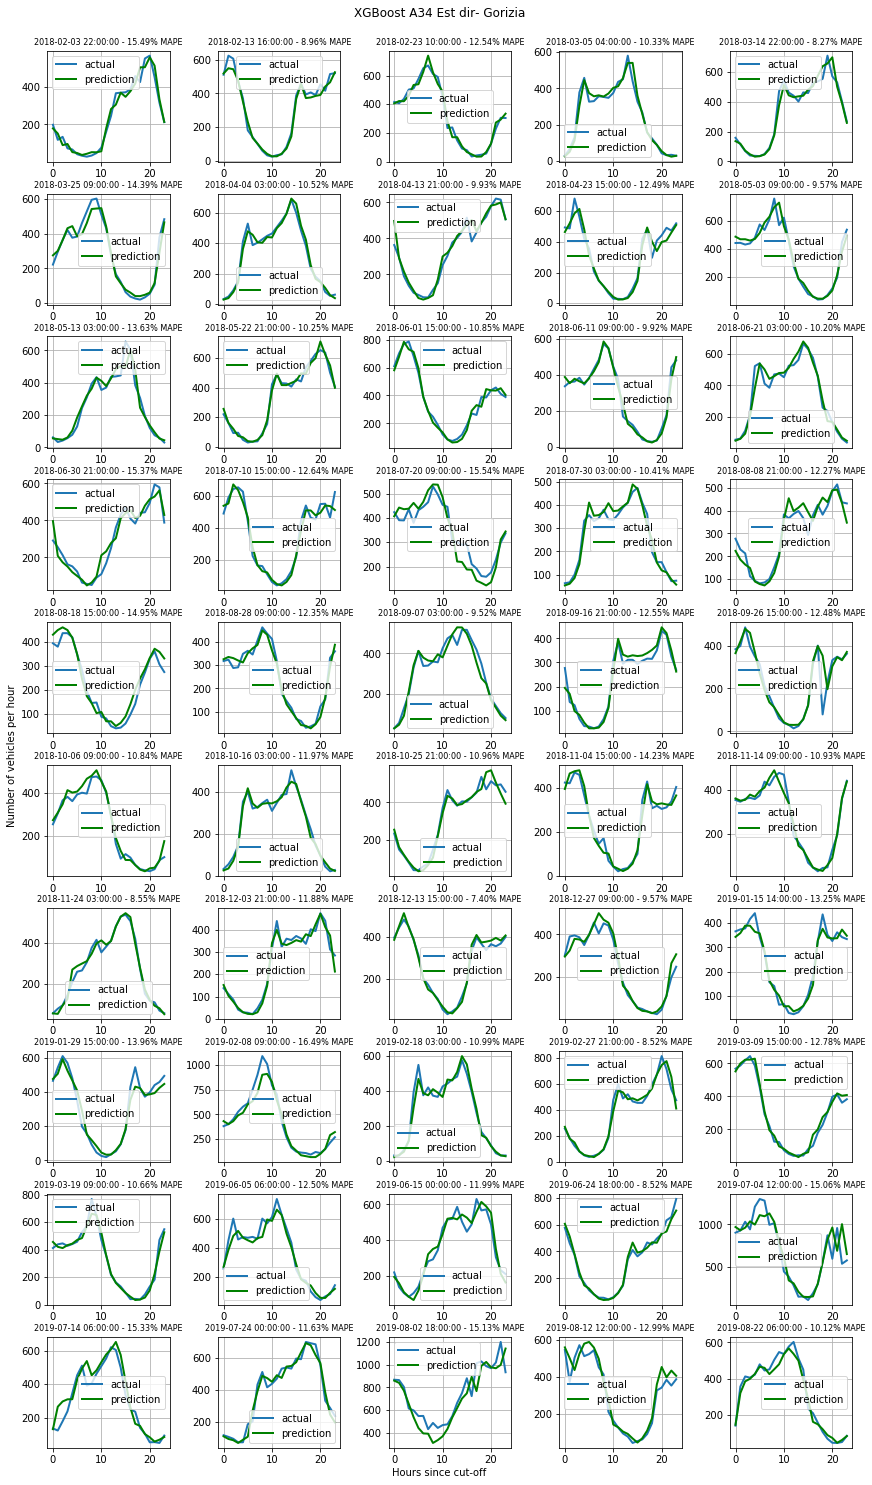

In [7]:
tscv = TimeSeriesSplit()
predictions = {}
for i_location, location in enumerate(locations):
    plts = 50
    cols = 5

    fig, axs = plt.subplots(int(plts/cols), cols, figsize=(12, int(2*plts/cols)))
    fig.suptitle(f'XGBoost {location}', y=1.02)
    fig.tight_layout()
    fig.text(0.5, 0.00, 'Hours since cut-off', ha='center')
    fig.text(0.00, 0.5, 'Number of vehicles per hour', va='center', rotation='vertical')

    dataframe = dataframes[location]
    # Perform evaluation on 2018 data only. Use 2015, 2016 and 2017 data for training
    data_y = dataframe.dropna()['count'].reset_index(drop=True)
    data_dates = dataframe.dropna()['date'].reset_index(drop=True)
    data_x = dataframe.dropna().drop(['count', 'date'], axis=1).reset_index(drop=True)
    
    data_x_initial = data_x.iloc[:20000]
    data_x_split = data_x.iloc[20000:]
    data_y_initial = data_y.iloc[:20000]
    data_y_split = data_y.iloc[20000:]
    data_dates = data_dates.iloc[20000:]
    
    predictions[location] = pd.DataFrame()
    tscv = TimeSeriesSplit(50)
    for i_tscv, (train_index, test_index) in enumerate(tscv.split(data_x_split)):
        X_train, X_test = data_x_split.iloc[train_index], data_x_split.iloc[test_index]
        y_train, y_test = data_y_split.iloc[train_index], data_y_split.iloc[test_index]
        test_dates = data_dates.iloc[test_index]
        X_train = pd.concat([data_x_initial, X_train])
        y_train = pd.concat([data_y_initial, y_train])
        X_test = X_test.iloc[:24]
        y_test = y_test.iloc[:24]
        test_dates = test_dates.iloc[:24]

        # standardize
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
#         X_train_scaled = X_train
#         X_test_scaled = X_test

#         lr = XGBRegressor()
        lr = XGBRegressor(objective='reg:squarederror')
    
        lr.fit(X_train_scaled, y_train)
        prediction = lr.predict(X_test_scaled)
        error = mean_absolute_percentage_error(prediction, y_test)
        
        predictions[location] = pd.concat([
            predictions[location],
            pd.DataFrame({
                "prediction": prediction,
                "y_test": y_test,
                "ds": test_dates
            })
        ])
        
        fig_i = i_tscv
        ax = axs[int(fig_i/cols)][int(fig_i%cols)]
        ax.plot(y_test.values[0:168], label="actual", linewidth=2.0)
        ax.plot(prediction[0:168], "g", label="prediction", linewidth=2.0)
        ax.title.set_text("{} - {:.2f}% MAPE".format(test_dates.iloc[0], error))
        ax.title.set_size(8)
        ax.legend(loc="best")
        ax.grid(True);
#         break
#     break

### Evaluation

In [8]:
a = predictions["Rabuiese Valico Uscita"]
(a["prediction"] - a["y_test"]).abs().mean()

32.98885106012225

In [9]:
predictions_df = pd.DataFrame()
for location in locations:
    data = predictions[location].copy()
    data["location"] = location
    predictions_df = pd.concat([predictions_df, data])

In [10]:
predictions_df["hour"] = predictions_df["ds"].dt.hour
predictions_df["abs_error"] = (predictions_df["prediction"] - predictions_df["y_test"]).abs()

In [11]:
predictions_df.pivot_table(columns="location", index="hour", values="abs_error", aggfunc=np.mean).round(1)


location  A34 Est dir- Gorizia  A34 Ovest dir- Villesse  \
hour                                                      
0                         20.6                     20.9   
1                         13.8                     22.7   
2                         14.6                     18.4   
3                         10.4                     20.5   
4                         13.5                     28.8   
5                         18.7                     21.5   
6                         14.1                     31.8   
7                         49.5                     42.6   
8                         46.3                     41.1   
9                         43.8                     37.7   
10                        34.6                     39.8   
11                        27.8                     31.5   
12                        25.1                     33.8   
13                        37.7                     23.4   
14                        26.7                     30.0   
15                        32.8                     30.7   
16                        42.6                     33.1   
17                        44.1                     36.9   
18                        41.6                     32.6   
19                        35.2                     31.4   
20                        31.0                     26.7   
21                        38.7                     22.2   
22                        22.7                     18.5   
23                        22.9                     24.3   

location  Fernetti Valico Ingresso  Fernetti Valico Uscita  \
hour                                                         
0                             16.4                    14.5   
1                             16.2                     8.6   
2                             12.8                    13.4   
3                             15.5                    10.0   
4                             22.3                    11.4   
5                             21.8                    18.5   
6                             33.0                    23.2   
7                             41.5                    24.6   
8                             45.5                    25.7   
9                             42.3                    26.2   
10                            47.3                    23.0   
11                            38.6                    26.9   
12                            38.2                    27.0   
13                            50.4                    32.0   
14                            29.8                    32.0   
15                            43.0                    33.7   
16                            32.6                    32.2   
17                            47.5                    39.8   
18                            40.0                    36.0   
19                            32.2                    28.6   
20                            23.9                    22.7   
21                            25.8                    26.5   
22                            28.7                    17.1   
23                            15.8                    14.1   

location  Prosecco Direzione TS  Prosecco Direzione VE  \
hour                                                     
0                          33.6                   27.8   
1                          23.1                   24.2   
2                          19.1                   19.7   
3                          18.1                   19.1   
4                          16.7                   35.8   
5                          24.2                   35.2   
6                          46.3                   37.1   
7                          95.3                   41.7   
8                          68.3                   46.2   
9                          61.8                   64.9   
10                         46.5                   67.4   
11                         62.7                   50.1   
12                         53.6         

In [12]:
result = predictions_df.copy().rename(columns={
    "prediction": "yhat",
    "y_test": "y"
})

In [13]:
error_metrics = pd.DataFrame()
for location in locations:
    data = result[result["location"] == location].copy()
    print(location)
    data["cutoff"] = pd.to_datetime("2020-04-10")
    err = performance_metrics(data, rolling_window=1)
    err["location"] = location
    error_metrics = pd.concat([error_metrics, err])
# #     display(err)

Rabuiese Valico Uscita
Rabuiese Valico Ingresso
Fernetti Valico Uscita
Fernetti Valico Ingresso
Prosecco Direzione TS
Prosecco Direzione VE
A34 Ovest dir- Villesse
A34 Est dir- Gorizia


In [14]:
temp = error_metrics.copy()
temp["mdape"] *= 100
temp = temp.round(2)
temp[["location", "mae", "rmse", "mdape"]]

location    mae   rmse  mdape
0    Rabuiese Valico Uscita  32.99  57.42  11.73
0  Rabuiese Valico Ingresso  35.36  62.50  12.97
0    Fernetti Valico Uscita  23.80  35.70  12.21
0  Fernetti Valico Ingresso  31.84  54.69   9.03
0     Prosecco Direzione TS  48.51  73.51   8.70
0     Prosecco Direzione VE  43.94  66.57   7.17
0   A34 Ovest dir- Villesse  29.20  43.13   7.07
0      A34 Est dir- Gorizia  29.54  46.39   8.43